In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
from hdbscan import HDBSCAN

import sys
sys.path.append("../Processing/")  

from utils import *

In [2]:
cora = pd.read_csv("../Embeddings/Cora_dataset_EMBS.csv")
abstracts = cora["Abstract"]
abstracts

0       Angeline, P., Saunders, G. and Pollack, J. (19...
1       This paper proposes using fuzzy logic techniqu...
2       fl The authors thank Rich Yee, Vijay Gullapall...
3       The problem of maximizing the expected total d...
4       Reinforcement learning (RL) has become a centr...
                              ...                        
2363    segmentation: Preliminary results Abstract. Sc...
2364    1] D. Aldous and P. Shields. A diffusion limit...
2365    This paper is a scientific comparison of two c...
2366    Paper and BibTeX entry are available at http:/...
2367    We investigate how abduction and induction can...
Name: Abstract, Length: 2368, dtype: object

In [ ]:
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)
embeddings.shape

In [12]:
cora['cluster_embs'] = list(embeddings)

### **Store the dataframe with the new embeddigs**
They might be useful

In [15]:
cora.to_csv("Cora_dataset.csv", index=False, encoding="utf-8")

### **Reduce Dimensionality with UMAP**

In [20]:
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)
print(f"Original embedding sizes: {embeddings.shape}")
print(f"New embedding sizes: {reduced_embeddings.shape}")

c:\Users\apala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original embedding sizes: (2368, 768)
New embedding sizes: (2368, 5)


### **Make the clusters**

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=25, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_
print(f"Number of clusters: {len(set(clusters))}")

Number of clusters: 19


c:\Users\apala\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\apala\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Visualizamos los 3 primeros documentos del cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[int(index)][:300] + "... \n")

The foremost goal of superscalar processor design is to increase performance through the exploitation of instruction-level parallelism (ILP). Previous studies have shown that speculative execution is required for high instruction per cycle (IPC) rates in non-numerical applications. The general trend... 

This paper discusses three techniques useful in relaxing the constraints imposed by control flow on parallelism: control dependence analysis, executing multiple flows of control simultaneously, and speculative execution. We evaluate these techniques by using trace simulations to find the limits of p... 

This paper examines the limits to instruction level parallelism that can be found in programs, in particular the SPEC95 benchmark suite. Apart from using a more recent version of the SPEC benchmark suite, it differs from earlier studies in removing non-essential true dependencies that occur as a res... 



In [ ]:
reduced_embeddings = UMAP(
  n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)


df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = cora["Title"]
df["cluster"] = [str(c) for c in clusters]


to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

c:\Users\apala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-4.550912535190582,
 15.540784275531768,
 0.7677933812141419,
 13.055545365810394)

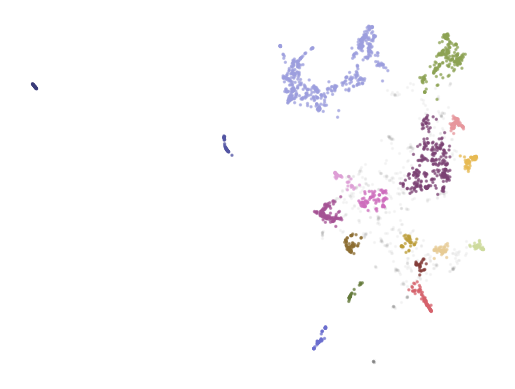

In [ ]:
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(
  to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
  alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

c:\Users\apala\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


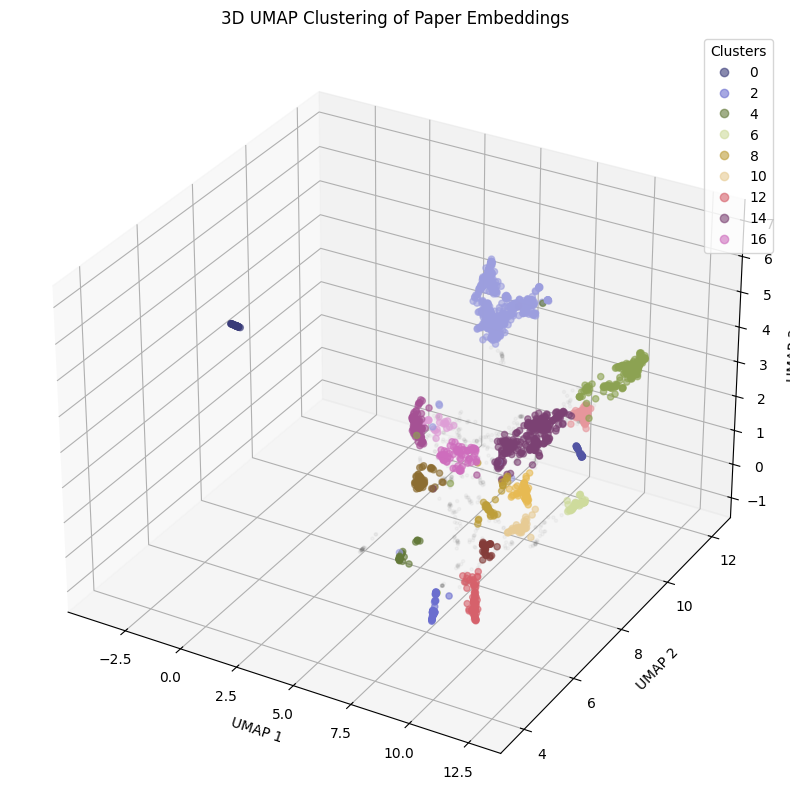

In [ ]:
# Reduce to 3D
reduced_embeddings_3d = umap.UMAP(
    n_components=3, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

df_3d = pd.DataFrame(reduced_embeddings_3d, columns=["x", "y", "z"])
df_3d["title"] = cora["Title"]
df_3d["cluster"] = [str(c) for c in clusters]

to_plot = df_3d.loc[df_3d.cluster != "-1", :]
outliers = df_3d.loc[df_3d.cluster == "-1", :]

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot outliers
ax.scatter(outliers.x, outliers.y, outliers.z, alpha=0.05, s=5, c="grey")

# Plot clusters
scatter = ax.scatter(
    to_plot.x, to_plot.y, to_plot.z, 
    c=to_plot.cluster.astype(int),
    alpha=0.6, s=20, cmap="tab20b"
)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.set_title("3D UMAP Clustering of Paper Embeddings")


plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


### **Try with BERT embeddings**

In [6]:
cora = pd.read_csv("../models/Cora_dataset_new_clsBERT.csv")
for col in ['bert_cls_embedding2']:
    cora[col] = cora[col].apply(parse_embedding_flexible)

bert_embs = np.vstack(cora["bert_cls_embedding2"].values)

In [ ]:
for col in ['BoW', 'Abstract_W2V', 'bert_embedding']:
    cora[col] = cora[col].apply(parse_embedding_flexible)

bert_embs = np.vstack(cora["bert_embedding"].values)

In [7]:
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(bert_embs)
print(f"Original embedding sizes: {bert_embs.shape}")
print(f"New embedding sizes: {reduced_embeddings.shape}")

Original embedding sizes: (2368, 768)
New embedding sizes: (2368, 5)


In [8]:
hdbscan_model = HDBSCAN(min_cluster_size=3, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_
print(f"Number of clusters: {len(set(clusters))}")

Number of clusters: 160


In [9]:
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[int(index)][:300] + "... \n")

Automated synthesis of analog electronic circuits is recognized as a difficult problem. Genetic programming was used to evolve b o t h the topology and the sizing ( n u m e r i c a l v a l u e s ) f o r e a c h component of a circuit that can perform source identification by correctly cl assify an i... 

The problem of protecting computer systems can be viewed generally as the problem of learning to distinguish self from other. We describe a method for change detection which is based on the generation of T cells in the immune system. Mathematical analysis reveals computational costs of the system, a... 

Self-organizing neural networks are briefly reviewed and compared with supervised learning algorithms like back-propagation. The power of self-organization networks is in their capability of displaying typical features in a transparent manner. This is successfully demonstrated with two applications ... 



(5.715471959114074, 12.815339827537537, 4.2923996925354, 14.811176967620849)

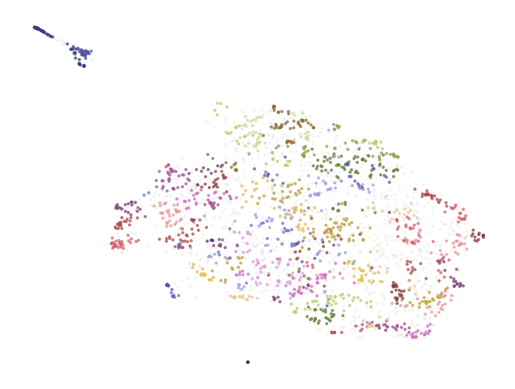

In [10]:
reduced_embeddings = UMAP(
  n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(bert_embs)


df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = cora["Title"]
df["cluster"] = [str(c) for c in clusters]


to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]


plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(
  to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
  alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

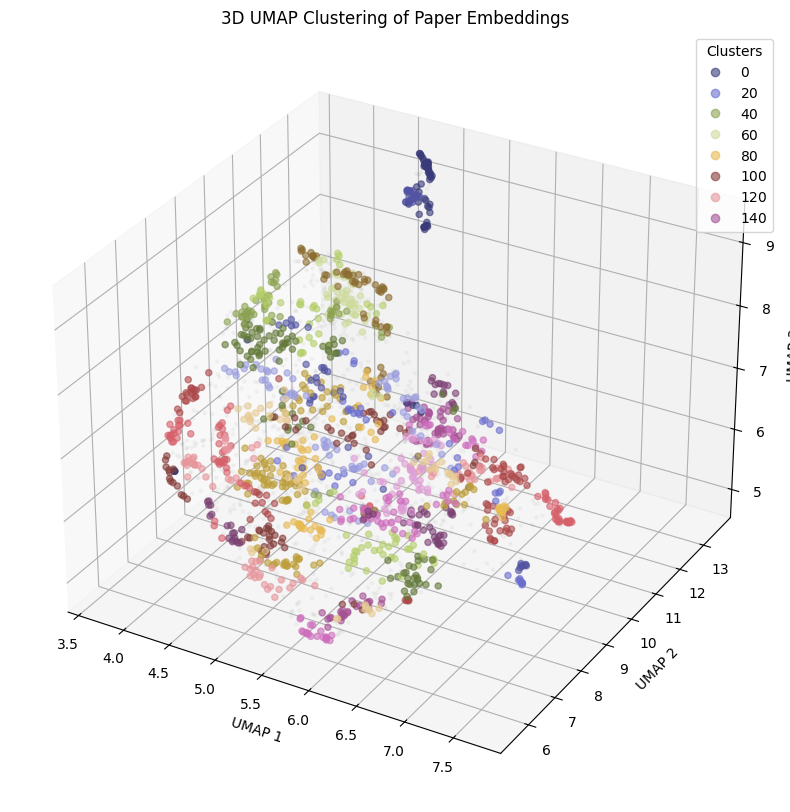

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap


reduced_embeddings_3d = umap.UMAP(
    n_components=3, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(bert_embs)


df_3d = pd.DataFrame(reduced_embeddings_3d, columns=["x", "y", "z"])
df_3d["title"] = cora["Title"]
df_3d["cluster"] = [str(c) for c in clusters]


to_plot = df_3d.loc[df_3d.cluster != "-1", :]
outliers = df_3d.loc[df_3d.cluster == "-1", :]

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(outliers.x, outliers.y, outliers.z, alpha=0.05, s=5, c="grey")


scatter = ax.scatter(
    to_plot.x, to_plot.y, to_plot.z, 
    c=to_plot.cluster.astype(int),
    alpha=0.6, s=20, cmap="tab20b"
)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.set_title("3D UMAP Clustering of Paper Embeddings")

plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


### **Store the hypergraph**

In [14]:
cora["cluster_hypergraph"] = list(clusters)

In [16]:
cora.to_csv("Cora_clusters.csv", index=False)

### **BERTopic**
Simply to take a glance at the predictions

In [53]:
topic_model = BERTopic(
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  verbose=True
).fit(abstracts, embeddings)

2025-11-25 17:12:45,143 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-25 17:12:52,418 - BERTopic - Dimensionality - Completed ✓
2025-11-25 17:12:52,420 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-25 17:12:52,457 - BERTopic - Cluster - Completed ✓
2025-11-25 17:12:52,467 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-25 17:12:52,632 - BERTopic - Representation - Completed ✓


In [54]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,669,-1_the_of_and_to,"[the, of, and, to, in, is, for, that, we, this]",[Let us present briefly the learning problem w...
1,0,563,0_the_of_to_and,"[the, of, to, and, in, is, that, genetic, we, ...",[All models of natural systems represent an ab...
2,1,208,1_case_the_of_reasoning,"[case, the, of, reasoning, based, to, and, in,...",[This article describes how a reasoner can imp...
3,2,107,2_the_of_visual_in,"[the, of, visual, in, and, to, is, that, model...",[We describe a biologically plausible model of...
4,3,91,3_decision_trees_tree_the,"[decision, trees, tree, the, of, that, we, and...",[We exhibit a theoretically founded algorithm ...
5,4,71,4_logic_ilp_of_examples,"[logic, ilp, of, examples, clauses, the, in, i...",[A novel approach to learning first order logi...
6,5,69,5_the_networks_of_and,"[the, networks, of, and, for, learning, percep...","[We compare kernel estimators, single and mult..."
7,6,67,6_recurrent_the_networks_of,"[recurrent, the, networks, of, network, to, an...",[This paper examines the inductive inference o...
8,7,66,7_chain_markov_the_of,"[chain, markov, the, of, sampling, sampler, co...","[Technical Report No. 9805, Department of Stat..."
9,8,60,8_learning_queries_of_we,"[learning, queries, of, we, the, in, pac, dnf,...",[In this paper we study learning in the PAC mo...


In [ ]:
fig = topic_model.visualize_documents(
  [t for t in cora["Title"]],
  reduced_embeddings=reduced_embeddings,
  width=1000,
  hide_annotations=True
)
fig.update_layout(font=dict(size=16))